In [3]:
# Import various libraries throughout the software
from pprint import pprint
import numpy as np
import datetime
import dateutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from geopy.distance import great_circle as vc
from copy import deepcopy
import math as Math

# Import from hurdat2 class in data folder and models class from hurricane-models folder
from data.hurdat2 import hurdat2
from errors.models import models

# Initialize Dataframe for hurricanes and error database
dataset = hurdat2("data/hurdat2.txt") # Note that this data includes up to and including 2016
errors = models("errors/1989-present_OFCL_v_BCD5_ind_ATL_TI_errors.txt")

# Show the first 5 records from Hurricane Katrina 2005 (AL122005)
dataset.hurricanes.query('storm_id == "AL122005"').head()

,storm_id,storm_name,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,...,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
14663,AL122005,KATRINA,2005-08-23 18:00:00,,TD,23.1N,75.1W,30,1008,0,...,0,0,0,0,0,0,0,0,0,0
14664,AL122005,KATRINA,2005-08-24 00:00:00,,TD,23.4N,75.7W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
14665,AL122005,KATRINA,2005-08-24 06:00:00,,TD,23.8N,76.2W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
14666,AL122005,KATRINA,2005-08-24 12:00:00,,TS,24.5N,76.5W,35,1006,60,...,0,0,0,0,0,0,0,0,0,0
14667,AL122005,KATRINA,2005-08-24 18:00:00,,TS,25.4N,76.9W,40,1003,60,...,0,0,0,0,0,0,0,0,0,0


# Transforming Data - Creating Hurricane Object

In [4]:
# Create hurricane class
class hurricane(object) : 
    def __init__(self, name, id) :
        # Set instance variables
        self.name = name
        self.id = id
        self.entries = dict()
        self.models = dict()
        
        return
    # Add hurricane track entry based on standard HURDAT2 format
    def add_entry(self, array) :
        entry = {
            array[0] : { # dateteime of entry
                'entry_time' : array[0], 
                'entry_id' : array[1],
                'entry_status' : array[2],
                'lat' : float(array[3][:-1]), # Convert to number from format '#.#N'
                'long' : float(array[4][:-1]), # Convert to number from format '#.#W'
                'max_wind' : float(array[5]),
                'min_pressure' : None if array[6] is None else float(array[6]), # Early records are -999 or None
                'wind_radii' :  array[7:], # Array based on HURDAT2 format
                'distance':0,
                'direction':0
            }
        }
        self.entries.update(entry)
        
        return
    def view_entry(self, key):
        print(self.entries.get(datetime.datetime.strptime(key, '%Y-%m-%d %H:%M:%S')))
        return
    # Add hurricane model errors
    def add_model(self, name, model) :
        self.models[name] = model
        
        return
# Storm ID Key for matching between datasets
storm_ids = dict()

# Parse in hurricanes
hurricanes = dict()
for index, entry in dataset.hurricanes.iterrows() :
    #print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset.hurricanes)), end = "\r")
    # New hurricane
    if entry['storm_id'] not in hurricanes :
        hurricanes[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_ids[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes[entry['storm_id']].add_entry(entry[2:])
print("\n Data Transformation Done!")


 Data Transformation Done!


# Feature Engineering and Data Augmentation
The shape on the input to the LSTM will be in a 3D array with the format [samples, timestamps, features]. In my case [9045, 4, 10] We will intitially begin with 1 time step and evaluate more can benefit our model. The output requires a 1 day forecast and observations without track data 1 days in the future will not be used.

In [5]:
global_var = {'lat' : [], 'long' : [], 'max_wind' : [], 'min_pressure' : [], 'year' : [], 'month' : [], 'day' : [], 'hour' : [],
         'distace' : [], 'angle' : []}
count = 0
def feature_extraction(timestep, previous) :
    '''
    PURPOSE: Calculate the features for a machine learning model within the context of hurricane-net
    METHOD: Use the predictors and the calculation methodology defined in Knaff 2013
    INPUT:  timestep - current dictionary of features in the hurricane object format
            previous - previous timestep dictionary of features in the hurricane object format
    OUTPUT: Dictionary of features
    '''
    
    dLon =  timestep['long'] - previous['long'];  
    temp = float(timestep['lat']) # p[0] is a str?
    y_x = Math.sin(dLon) * Math.cos(temp);
        
    x_x = Math.cos(timestep['long']) * Math.sin(temp) - Math.sin(timestep['long']) * Math.cos(temp) * Math.cos(dLon);
    brng = Math.degrees(Math.atan2(y_x, x_x)) 
    if (brng < 0):
        brng+= 360;
    
    features = {
        'lat' : timestep['lat'],
        'long' : timestep['long'],
        'max_wind' : timestep['max_wind'],
        'min_pressure' : timestep['min_pressure'], 
        'year' : timestep['entry_time'].year,
        'month' : timestep['entry_time'].month,
        'day' : timestep['entry_time'].day,
        'hour' : timestep['entry_time'].hour,
        'distace': vc((previous['lat'],previous['long']),( timestep['lat'],timestep['long'])).miles,
        'angle': brng,
    }
    
    global count ;
    count += 1
    if count <10:
        for key in features:
            global_var[key].append(features[key])
    return features
    
def storm_x_y(storm, timesteps = 1, lag = 6) :
    '''
    PURPOSE: Create independent and dependent samples for a machine learning model based on the timesteps
    METHOD: Use the HURDAT2 database and a hurricane object as defined in hurricane-net for feature extraction
    INPUT:  storm - hurricane object
            timesteps - (default = 1) number of timesteps to calculate
            include_none - (default = False) Boolean for including None in test data. Imputing function unavailable.
            lag - (default = 24) lag in hours for the dependent variables up to 5 days
    OUTPUT: Dictionary with independent (x) and dependent (y) values.
    '''
    x = []
    # Create testing data structure with a dictionary
    
    times = [time * lag for time in range(1, (24 // lag) + 1)] # [6, 12, 18, 24]
    y = dict([(time,[]) for time in times])
    # Sort by entry time
    entries = [entry[1] for entry in sorted(storm.entries.items())]
    
    for index in range(len(entries)) :
        if index < timesteps : # Flag for insufficient initial time steps
            continue

        # If we're not including None values, check to see if there will be any
        if None in [storm.entries.get(entries[index]['entry_time'] +
                                         datetime.timedelta(hours = future)) for future in times] : break
            
        # Calculate time steps and their features for independent values
        sample = []
        sample_features = []
        for step in range(timesteps) :
            # Training sample
            timestep = entries[index - step]
            previous = entries[index - step - 1]
            sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
            sample_features.append(feature_extraction(timestep, previous))
        x.append(sample) # Add our constructed sample
        # Calculate time steps and their features for dependent values
        for future in times :
            timestep = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future))
            previous = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future - lag))
            
            if timestep and previous: 
                y[future].append(feature_extraction(timestep, previous))
            else :
                y[future].append(None)
    
    # Return output, if there is no output, return None.
    if len(x) is 0 :
        return None
    else:
        return {'x': x, 'y': y}
def shape(hurricanes, timesteps, remove_missing = True) :
    '''
    PURPOSE: Shape our data for input into machine learning models
    METHOD: Use a numpy array to shape into (samples, timesteps, features)
    INPUT:  hurricanes - dictionary of hurricane objects
            timesteps - number of timesteps for the shape
            remove_missing - boolean indicating whether the algorithm will disregard missing values
    OUTPUT: numpy array of shape (samples, timesteps, 11) where 11 is the number of predictors in a hurricane object
    '''
    x = []
    y = []
    lag = 6# lag time in hours
    precision = np.float64 # defines the precision of our data type
    times = [time * lag for time in range(1, (24 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    count = 0
    for hurricane in hurricanes.values() :
        count += 1
        result = storm_x_y(hurricane, timesteps, lag)
        if result is None :
            continue
        # Extract only the values from the strom features using our specified precision
        hurricane_x = np.array(
            [[list(sample[1][0].values()) for sample in x] for x in result['x']],
            dtype = precision)
        hurricane_y = np.array(
            [[list(result['y'][time][index].values()) for time in times] for index in range(len(result['y'][lag]))],
            dtype = precision)
        # Disregard if algorithm requires no missing values
        if remove_missing :
            if (len(np.where(np.isnan(hurricane_x))[0]) > 0) or (len(np.where(np.isnan(hurricane_y))[0]) > 0) :
                continue
        # Add to our results
        x.extend(hurricane_x)
        y.extend(hurricane_y)
        print("Feature engineered {}/{} hurricanes for {} timestep(s)".format(count, len(hurricanes), timesteps), end = "\r")
    print("\nDone feature engineering hurricanes.")
    
    return {'x': np.array(x), 'y': np.array(y)}
def scaler(processed_data, hurricanes) :
    '''
    PURPOSE: Scale our data using the RobustScaler method from the sklearn library
    METHOD: Generate data using 1 timesteps and then remove the NaN or None types to use the scaler methods
    INPUT:  hurricanes - dictionary of hurricane objects
            processed_data - dictionary of x and y values of data produced by shape() function with no missing values
    OUTPUT: 1) Scaled processed_data using RobustScaler
            2) RobustScaler object fit with appropriate data
    '''
    print("Scaling Data . . . (1 timestep for unqiue data)")
    # Create our scaler
    unqiue_data = shape(hurricanes, timesteps = 1)
    x = np.reshape(unqiue_data['x'], (unqiue_data['x'].shape[0], -1))
    x = np.delete(x, np.where(np.isnan(x))[0], 0)
    scaler = RobustScaler()
    scaler.fit(x)
    
    # Scale our data
    for index in range(len(processed_data['x'])) :
        if index == 1:
            print(' Before scaling ', processed_data['x'][index], '/n')
            
        # Scale our x
        processed_data['x'][index] = scaler.transform(processed_data['x'][index])
        if index == 1:
            print(' After scaling ', processed_data['x'][index], '/n')
        # Scale our y
        processed_data['y'][index] = scaler.transform(processed_data['y'][index])
    print("Done scaling.")
    return processed_data, scaler
# Finalize and scale procesed data into a dictionary
preprocessed_data = shape(hurricanes, timesteps = 4)
print('preprocessed data ',preprocessed_data['x'].shape)
preprocessed_data_unmodfied = deepcopy(preprocessed_data)
processed_data, scaler = scaler(preprocessed_data, hurricanes)

# df = pd.DataFrame(global_var, index = ['lat', 'long', 'max_wind', 'min_pressure', 'year', 'month', 'day', 'hour', 'distance', 'angle'])
# df = pd.DataFrame([x for x in global_var])
# df = pd.DataFrame.from_dict(global_var).head()
df = pd.DataFrame(global_var)




Feature engineered 764/764 hurricanes for 4 timestep(s)
Done feature engineering hurricanes.
preprocessed data  (9045, 4, 10)
Scaling Data . . . (1 timestep for unqiue data)
Feature engineered 764/764 hurricanes for 1 timestep(s)
Done feature engineering hurricanes.
 Before scaling  [[  32.4          78.7          25.         1012.         1975.
     6.           28.            6.           62.45981791  184.30495435]
 [  31.5          78.8          25.         1012.         1975.
     6.           28.            0.           70.10132456  310.6687682 ]
 [  30.5          79.           25.         1013.         1975.
     6.           27.           18.           69.09342174    0.        ]
 [  29.5          79.           25.         1013.         1975.
     6.           27.           12.           69.09342174   -0.        ]] /n
 After scaling  [[ 0.54166667  0.69178082 -0.57142857  0.63157895 -1.38888889 -3.
   0.75        0.         -0.13331622  0.03030072]
 [ 0.47916667  0.69520548 -0.57

In [33]:
df = pd.DataFrame.from_dict(global_var)

In [34]:
df

,lat,long,max_wind,min_pressure,year,month,day,hour,distace,angle
0,12.5,80.5,25.0,NaN,1970,5,18,18,30.324220,25.218066
1,12.5,80.5,25.0,NaN,1970,5,18,18,30.324220,25.218066
2,12.3,80.1,25.0,1007.0,1970,5,18,12,30.342515,22.855027
3,12.3,80.1,25.0,1007.0,1970,5,18,12,30.342515,22.855027
4,12.1,79.7,25.0,NaN,1970,5,18,6,43.664025,25.490162
5,12.1,79.7,25.0,NaN,1970,5,18,6,43.664025,25.490162
6,11.7,79.2,25.0,NaN,1970,5,18,0,19.344019,7.396331
7,11.7,79.2,25.0,NaN,1970,5,18,0,19.344019,7.396331
8,13.0,81.0,25.0,NaN,1970,5,19,0,48.257754,27.719906


# Plotting scaled y versus original x

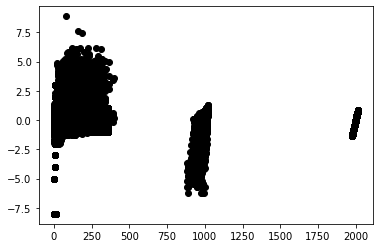

In [9]:
plt.scatter(preprocessed_data_unmodfied['x'][:-1], preprocessed_data['y'][:-1], color='black')
# plt.savefig('points_vs_distance', dpi=600)
plt.show()



# Plotting scaled y against scaled x

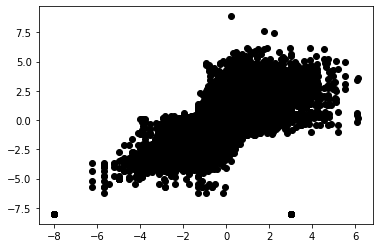

In [101]:
plt.scatter(preprocessed_data['x'][:-1], preprocessed_data['y'][:-1], color='black')
# plt.savefig('points_vs_distance', dpi=600)
plt.show()

In [103]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from sklearn import model_selection

# Create our cross validation data structure
X_train, X_test, y_train, y_test = model_selection.train_test_split(processed_data['x'], processed_data['y'],
                                                                    test_size = 0.2)

# Train for latitude and longitude location
y_train_lat = np.array([[[features[0]] for features in y] for y in y_train], dtype = np.float64)
y_test_lat = np.array([[[features[0]] for features in y] for y in y_test], dtype = np.float64)
y_train_long = np.array([[[features[1]] for features in y] for y in y_train], dtype = np.float64)
y_test_long = np.array([[[features[1]] for features in y] for y in y_test], dtype = np.float64)


def bd_lstm_td(X_train, y_train, X_test, y_test, n_epochs = 500) :    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 512, return_sequences = True, dropout = 0.05),
                            input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(units = 256, return_sequences = True, dropout = 0.05))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adadelta')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

def lstm_td(X_train, X_test, y_train, y_test, n_epochs= 300) :
    print(X_train.shape)
    model = Sequential()
    model.add(LSTM(units = 1024, input_shape = (4,10), return_sequences = True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs, validation_data = (X_test, y_test))
    
    return model, history

model_lat, model_lat_history = lstm_td(X_train,X_test,  y_train_lat,  y_test_lat, n_epochs = 600)
model_long, model_long_history = lstm_td(X_train, X_test, y_train_long,  y_test_long, n_epochs = 600)

(7236, 4, 10)
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 4, 1024)           4239360   
_________________________________________________________________
time_distributed_17 (TimeDis (None, 4, 1)              1025      
Total params: 4,240,385
Trainable params: 4,240,385
Non-trainable params: 0
_________________________________________________________________
None
Train on 7236 samples, validate on 1809 samples
Epoch 1/600
7236/7236 [==============================] - 13s 2ms/step - loss: 0.5100 - accuracy: 0.0024 - val_loss: 0.4226 - val_accuracy: 0.0029
Epoch 2/600
7236/7236 [==============================] - 12s 2ms/step - loss: 0.4093 - accuracy: 0.0024 - val_loss: 0.3363 - val_accuracy: 0.0039
Epoch 3/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.3282 - accuracy: 0.0028 - val_loss: 0.2753 - val_accuracy: 0.0048


7236/7236 [==============================] - 11s 2ms/step - loss: 0.0519 - accuracy: 0.0063 - val_loss: 0.0512 - val_accuracy: 0.0069
Epoch 53/600
7236/7236 [==============================] - 13s 2ms/step - loss: 0.0511 - accuracy: 0.0064 - val_loss: 0.0505 - val_accuracy: 0.0069
Epoch 54/600
7236/7236 [==============================] - 14s 2ms/step - loss: 0.0504 - accuracy: 0.0064 - val_loss: 0.0499 - val_accuracy: 0.0069
Epoch 55/600
7236/7236 [==============================] - 15s 2ms/step - loss: 0.0497 - accuracy: 0.0064 - val_loss: 0.0493 - val_accuracy: 0.0069
Epoch 56/600
7236/7236 [==============================] - 13s 2ms/step - loss: 0.0490 - accuracy: 0.0064 - val_loss: 0.0487 - val_accuracy: 0.0069
Epoch 57/600
7236/7236 [==============================] - 14s 2ms/step - loss: 0.0484 - accuracy: 0.0064 - val_loss: 0.0481 - val_accuracy: 0.0069
Epoch 58/600
7236/7236 [==============================] - 13s 2ms/step - loss: 0.0477 - accuracy: 0.0064 - val_loss: 0.0473 - val_a

Epoch 108/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0226 - accuracy: 0.0065 - val_loss: 0.0220 - val_accuracy: 0.0072
Epoch 109/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0223 - accuracy: 0.0065 - val_loss: 0.0217 - val_accuracy: 0.0072
Epoch 110/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0220 - accuracy: 0.0065 - val_loss: 0.0214 - val_accuracy: 0.0072
Epoch 111/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0218 - accuracy: 0.0065 - val_loss: 0.0212 - val_accuracy: 0.0072
Epoch 112/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0215 - accuracy: 0.0065 - val_loss: 0.0209 - val_accuracy: 0.0072
Epoch 113/600
7236/7236 [==============================] - 11s 2ms/step - loss: 0.0213 - accuracy: 0.0065 - val_loss: 0.0207 - val_accuracy: 0.0072
Epoch 114/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0210 - accuracy: 0.0065 - val_

Epoch 164/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0174 - accuracy: 0.0065 - val_loss: 0.0172 - val_accuracy: 0.0072
Epoch 165/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0173 - accuracy: 0.0065 - val_loss: 0.0171 - val_accuracy: 0.0072
Epoch 166/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0173 - accuracy: 0.0065 - val_loss: 0.0171 - val_accuracy: 0.0072
Epoch 167/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0172 - accuracy: 0.0065 - val_loss: 0.0171 - val_accuracy: 0.0072
Epoch 168/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0172 - accuracy: 0.0065 - val_loss: 0.0170 - val_accuracy: 0.0072
Epoch 169/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0172 - accuracy: 0.0065 - val_loss: 0.0170 - val_accuracy: 0.0072
Epoch 170/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0171 - accuracy: 0.0065 - val_

Epoch 220/600
7236/7236 [==============================] - 11s 2ms/step - loss: 0.0145 - accuracy: 0.0066 - val_loss: 0.0147 - val_accuracy: 0.0072
Epoch 221/600
7236/7236 [==============================] - 11s 2ms/step - loss: 0.0144 - accuracy: 0.0066 - val_loss: 0.0146 - val_accuracy: 0.0072
Epoch 222/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0144 - accuracy: 0.0066 - val_loss: 0.0145 - val_accuracy: 0.0072
Epoch 223/600
7236/7236 [==============================] - 11s 2ms/step - loss: 0.0143 - accuracy: 0.0066 - val_loss: 0.0145 - val_accuracy: 0.0072
Epoch 224/600
7236/7236 [==============================] - 12s 2ms/step - loss: 0.0142 - accuracy: 0.0066 - val_loss: 0.0144 - val_accuracy: 0.0072
Epoch 225/600
7236/7236 [==============================] - 12s 2ms/step - loss: 0.0142 - accuracy: 0.0066 - val_loss: 0.0144 - val_accuracy: 0.0072
Epoch 226/600
7236/7236 [==============================] - 12s 2ms/step - loss: 0.0141 - accuracy: 0.0066 - val_

Epoch 276/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0118 - accuracy: 0.0066 - val_loss: 0.0123 - val_accuracy: 0.0072
Epoch 277/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0118 - accuracy: 0.0066 - val_loss: 0.0122 - val_accuracy: 0.0072
Epoch 278/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0117 - accuracy: 0.0066 - val_loss: 0.0122 - val_accuracy: 0.0072
Epoch 279/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0117 - accuracy: 0.0066 - val_loss: 0.0121 - val_accuracy: 0.0072
Epoch 280/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0116 - accuracy: 0.0066 - val_loss: 0.0121 - val_accuracy: 0.0072
Epoch 281/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0116 - accuracy: 0.0066 - val_loss: 0.0120 - val_accuracy: 0.0072
Epoch 282/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0116 - accuracy: 0.0066 - val_

Epoch 332/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0101 - accuracy: 0.0066 - val_loss: 0.0110 - val_accuracy: 0.0072
Epoch 333/600
7236/7236 [==============================] - 11s 2ms/step - loss: 0.0103 - accuracy: 0.0066 - val_loss: 0.0113 - val_accuracy: 0.0072
Epoch 334/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0106 - accuracy: 0.0066 - val_loss: 0.0116 - val_accuracy: 0.0072
Epoch 335/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0109 - accuracy: 0.0066 - val_loss: 0.0116 - val_accuracy: 0.0072
Epoch 336/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0109 - accuracy: 0.0066 - val_loss: 0.0111 - val_accuracy: 0.0072
Epoch 337/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0105 - accuracy: 0.0066 - val_loss: 0.0104 - val_accuracy: 0.0072
Epoch 338/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0098 - accuracy: 0.0066 - val_

Epoch 388/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0084 - accuracy: 0.0066 - val_loss: 0.0091 - val_accuracy: 0.0072
Epoch 389/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0085 - accuracy: 0.0066 - val_loss: 0.0092 - val_accuracy: 0.0072
Epoch 390/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0086 - accuracy: 0.0066 - val_loss: 0.0093 - val_accuracy: 0.0072
Epoch 391/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0086 - accuracy: 0.0066 - val_loss: 0.0094 - val_accuracy: 0.0072
Epoch 392/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0088 - accuracy: 0.0066 - val_loss: 0.0096 - val_accuracy: 0.0072
Epoch 393/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0089 - accuracy: 0.0066 - val_loss: 0.0098 - val_accuracy: 0.0072
Epoch 394/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0091 - accuracy: 0.0066 - val_

Epoch 444/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0079 - accuracy: 0.0066 - val_loss: 0.0086 - val_accuracy: 0.0072
Epoch 445/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0079 - accuracy: 0.0066 - val_loss: 0.0084 - val_accuracy: 0.0072
Epoch 446/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0078 - accuracy: 0.0066 - val_loss: 0.0084 - val_accuracy: 0.0072
Epoch 447/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0078 - accuracy: 0.0066 - val_loss: 0.0083 - val_accuracy: 0.0072
Epoch 448/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0077 - accuracy: 0.0066 - val_loss: 0.0083 - val_accuracy: 0.0072
Epoch 449/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0076 - accuracy: 0.0066 - val_loss: 0.0082 - val_accuracy: 0.0072
Epoch 450/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0076 - accuracy: 0.0066 - val_

Epoch 500/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0073 - accuracy: 0.0066 - val_loss: 0.0079 - val_accuracy: 0.0072
Epoch 501/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0072 - accuracy: 0.0066 - val_loss: 0.0078 - val_accuracy: 0.0072
Epoch 502/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0072 - accuracy: 0.0066 - val_loss: 0.0079 - val_accuracy: 0.0072
Epoch 503/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0072 - accuracy: 0.0066 - val_loss: 0.0078 - val_accuracy: 0.0072
Epoch 504/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0072 - accuracy: 0.0066 - val_loss: 0.0078 - val_accuracy: 0.0072
Epoch 505/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0072 - accuracy: 0.0066 - val_loss: 0.0078 - val_accuracy: 0.0072
Epoch 506/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0072 - accuracy: 0.0066 - val_

Epoch 556/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0068 - accuracy: 0.0066 - val_loss: 0.0074 - val_accuracy: 0.0072
Epoch 557/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0068 - accuracy: 0.0066 - val_loss: 0.0074 - val_accuracy: 0.0072
Epoch 558/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0068 - accuracy: 0.0066 - val_loss: 0.0074 - val_accuracy: 0.0072
Epoch 559/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0068 - accuracy: 0.0066 - val_loss: 0.0074 - val_accuracy: 0.0072
Epoch 560/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0068 - accuracy: 0.0066 - val_loss: 0.0074 - val_accuracy: 0.0072
Epoch 561/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0068 - accuracy: 0.0066 - val_loss: 0.0074 - val_accuracy: 0.0072
Epoch 562/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0068 - accuracy: 0.0066 - val_

Epoch 7/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.1588 - accuracy: 0.0021 - val_loss: 0.1451 - val_accuracy: 0.0029
Epoch 8/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.1469 - accuracy: 0.0021 - val_loss: 0.1365 - val_accuracy: 0.0029
Epoch 9/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.1378 - accuracy: 0.0023 - val_loss: 0.1319 - val_accuracy: 0.0032
Epoch 10/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.1327 - accuracy: 0.0023 - val_loss: 0.1300 - val_accuracy: 0.0032
Epoch 11/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.1304 - accuracy: 0.0023 - val_loss: 0.1265 - val_accuracy: 0.0033
Epoch 12/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.1268 - accuracy: 0.0024 - val_loss: 0.1193 - val_accuracy: 0.0033
Epoch 13/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.1194 - accuracy: 0.0024 - val_loss: 0.11

Epoch 63/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0333 - accuracy: 0.0027 - val_loss: 0.0325 - val_accuracy: 0.0037
Epoch 64/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0327 - accuracy: 0.0028 - val_loss: 0.0319 - val_accuracy: 0.0037
Epoch 65/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0320 - accuracy: 0.0028 - val_loss: 0.0313 - val_accuracy: 0.0037
Epoch 66/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0314 - accuracy: 0.0028 - val_loss: 0.0307 - val_accuracy: 0.0037
Epoch 67/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0308 - accuracy: 0.0028 - val_loss: 0.0301 - val_accuracy: 0.0037
Epoch 68/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0302 - accuracy: 0.0028 - val_loss: 0.0295 - val_accuracy: 0.0039
Epoch 69/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0296 - accuracy: 0.0028 - val_loss: 0

Epoch 119/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0106 - accuracy: 0.0028 - val_loss: 0.0105 - val_accuracy: 0.0039
Epoch 120/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0105 - accuracy: 0.0028 - val_loss: 0.0104 - val_accuracy: 0.0039
Epoch 121/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0104 - accuracy: 0.0028 - val_loss: 0.0104 - val_accuracy: 0.0039
Epoch 122/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0103 - accuracy: 0.0028 - val_loss: 0.0103 - val_accuracy: 0.0039
Epoch 123/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0102 - accuracy: 0.0028 - val_loss: 0.0102 - val_accuracy: 0.0039
Epoch 124/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0101 - accuracy: 0.0028 - val_loss: 0.0101 - val_accuracy: 0.0039
Epoch 125/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0101 - accuracy: 0.0028 - val_

Epoch 175/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0086 - accuracy: 0.0028 - val_loss: 0.0088 - val_accuracy: 0.0039
Epoch 176/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0086 - accuracy: 0.0028 - val_loss: 0.0088 - val_accuracy: 0.0039
Epoch 177/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0086 - accuracy: 0.0028 - val_loss: 0.0088 - val_accuracy: 0.0039
Epoch 178/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0086 - accuracy: 0.0028 - val_loss: 0.0087 - val_accuracy: 0.0039
Epoch 179/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0085 - accuracy: 0.0028 - val_loss: 0.0087 - val_accuracy: 0.0039
Epoch 180/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0085 - accuracy: 0.0028 - val_loss: 0.0087 - val_accuracy: 0.0039
Epoch 181/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0085 - accuracy: 0.0028 - val_

Epoch 231/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0078 - accuracy: 0.0028 - val_loss: 0.0080 - val_accuracy: 0.0039
Epoch 232/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0078 - accuracy: 0.0028 - val_loss: 0.0080 - val_accuracy: 0.0039
Epoch 233/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0077 - accuracy: 0.0028 - val_loss: 0.0080 - val_accuracy: 0.0039
Epoch 234/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0077 - accuracy: 0.0028 - val_loss: 0.0080 - val_accuracy: 0.0039
Epoch 235/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0077 - accuracy: 0.0028 - val_loss: 0.0079 - val_accuracy: 0.0039
Epoch 236/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0077 - accuracy: 0.0028 - val_loss: 0.0079 - val_accuracy: 0.0039
Epoch 237/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0077 - accuracy: 0.0028 - val_

Epoch 287/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0075 - accuracy: 0.0028 - val_loss: 0.0073 - val_accuracy: 0.0039
Epoch 288/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0070 - accuracy: 0.0028 - val_loss: 0.0071 - val_accuracy: 0.0039
Epoch 289/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0068 - accuracy: 0.0028 - val_loss: 0.0075 - val_accuracy: 0.0039
Epoch 290/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0072 - accuracy: 0.0028 - val_loss: 0.0073 - val_accuracy: 0.0039
Epoch 291/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0070 - accuracy: 0.0028 - val_loss: 0.0071 - val_accuracy: 0.0039
Epoch 292/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0067 - accuracy: 0.0028 - val_loss: 0.0073 - val_accuracy: 0.0039
Epoch 293/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0070 - accuracy: 0.0028 - val_

Epoch 343/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0059 - accuracy: 0.0028 - val_loss: 0.0063 - val_accuracy: 0.0039
Epoch 344/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0059 - accuracy: 0.0028 - val_loss: 0.0063 - val_accuracy: 0.0039
Epoch 345/600
7236/7236 [==============================] - 11s 2ms/step - loss: 0.0059 - accuracy: 0.0028 - val_loss: 0.0063 - val_accuracy: 0.0039
Epoch 346/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0059 - accuracy: 0.0028 - val_loss: 0.0063 - val_accuracy: 0.0039
Epoch 347/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0060 - accuracy: 0.0028 - val_loss: 0.0064 - val_accuracy: 0.0039
Epoch 348/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0061 - accuracy: 0.0028 - val_loss: 0.0067 - val_accuracy: 0.0039
Epoch 349/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0064 - accuracy: 0.0028 - val_

Epoch 399/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0053 - accuracy: 0.0028 - val_loss: 0.0057 - val_accuracy: 0.0039
Epoch 400/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0053 - accuracy: 0.0028 - val_loss: 0.0056 - val_accuracy: 0.0039
Epoch 401/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0053 - accuracy: 0.0028 - val_loss: 0.0056 - val_accuracy: 0.0039
Epoch 402/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0053 - accuracy: 0.0028 - val_loss: 0.0056 - val_accuracy: 0.0039
Epoch 403/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0053 - accuracy: 0.0028 - val_loss: 0.0056 - val_accuracy: 0.0039
Epoch 404/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0052 - accuracy: 0.0028 - val_loss: 0.0056 - val_accuracy: 0.0039
Epoch 405/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0052 - accuracy: 0.0028 - val_

Epoch 455/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0051 - accuracy: 0.0028 - val_loss: 0.0056 - val_accuracy: 0.0039
Epoch 456/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0053 - accuracy: 0.0028 - val_loss: 0.0058 - val_accuracy: 0.0039
Epoch 457/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0054 - accuracy: 0.0028 - val_loss: 0.0053 - val_accuracy: 0.0039
Epoch 458/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0049 - accuracy: 0.0028 - val_loss: 0.0058 - val_accuracy: 0.0039
Epoch 459/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0054 - accuracy: 0.0028 - val_loss: 0.0052 - val_accuracy: 0.0039
Epoch 460/600
7236/7236 [==============================] - 11s 2ms/step - loss: 0.0048 - accuracy: 0.0028 - val_loss: 0.0058 - val_accuracy: 0.0039
Epoch 461/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0053 - accuracy: 0.0028 - val_

Epoch 511/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0044 - accuracy: 0.0028 - val_loss: 0.0048 - val_accuracy: 0.0039
Epoch 512/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0044 - accuracy: 0.0028 - val_loss: 0.0048 - val_accuracy: 0.0039
Epoch 513/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0043 - accuracy: 0.0028 - val_loss: 0.0048 - val_accuracy: 0.0039
Epoch 514/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0043 - accuracy: 0.0028 - val_loss: 0.0048 - val_accuracy: 0.0039
Epoch 515/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0043 - accuracy: 0.0028 - val_loss: 0.0047 - val_accuracy: 0.0039
Epoch 516/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0043 - accuracy: 0.0028 - val_loss: 0.0047 - val_accuracy: 0.0039
Epoch 517/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0043 - accuracy: 0.0028 - val_

Epoch 567/600
7236/7236 [==============================] - 10s 1ms/step - loss: 0.0039 - accuracy: 0.0028 - val_loss: 0.0044 - val_accuracy: 0.0039
Epoch 568/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0039 - accuracy: 0.0028 - val_loss: 0.0043 - val_accuracy: 0.0039
Epoch 569/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0039 - accuracy: 0.0028 - val_loss: 0.0044 - val_accuracy: 0.0039
Epoch 570/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0039 - accuracy: 0.0028 - val_loss: 0.0044 - val_accuracy: 0.0039
Epoch 571/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0040 - accuracy: 0.0028 - val_loss: 0.0048 - val_accuracy: 0.0039
Epoch 572/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0043 - accuracy: 0.0028 - val_loss: 0.0056 - val_accuracy: 0.0039
Epoch 573/600
7236/7236 [==============================] - 11s 1ms/step - loss: 0.0052 - accuracy: 0.0028 - val_

# Evaluating Performance of Model

In [1]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def ai_errors(predictions, observations, history = None) :
    '''
    PURPOSE: Provide descriptive statistics on the predicted output versus the observed measurments
    METHOD:  Take the errors of the predictions and answers and then calculate standard descriptive statistics
    INPUT:   predictions - 2D array of predictions of observed output
             observations - 2D array measurements of observed output
             history - Keras history model for displaying model loss, default is None if not available
    OUTPUT:
    '''
    errors = [];
    observations_array = [];
    predictions_array = [];

    for i in range(len(predictions)) :
        for j in range(len(predictions[i])) :
            # Calculate errors           
            predictions_array.append(predictions[i][j]);
            observations_array.append(observations[i][j]);        
            error = predictions[i][j] - observations[i][j];
            errors.append(error)
    #acc= model_lat.evaluate(observations_array,predictions_array);
    #print('acc: ' ,acc)
    mse = mean_squared_error(observations_array, predictions_array);  
    rms = sqrt(mse);
    
#  THE RMS OR root mean square calculation is almost equivalent to the STANDARD DEVIATION(std) in the error distribution
#   The RMSE for your training and your test sets should be very similar if you have built a good model. If the RMSE for the
#   test set is much higher than that of the training set, it is likely that you've badly over fit the data

    print('\n rms ',rms)
    print('\n mse ',mse)

    # Display history and erros
    plt.figure(1)
    plt.hist(errors, bins = 50)
    plt.title('error histogram')
    plt.xlabel('error')
    plt.ylabel('frequency')
    plt.grid(True)
    
    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return  pd.DataFrame(errors)

# Predict values
lat_predictions = model_lat.predict(X_test)
long_predictions = model_long.predict(X_test)

# print( '* *******LAT PREDICTION*******',lat_predictions )
# print( '* *******LAT lat_predictions_scaled*******',lat_predictions_scaled )


# Scale back our predictions

# Latitude
lat_predictions_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0] for lat in prediction])
                          for prediction in lat_predictions]

y_lat_test_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0] for lat in observation])
                     for observation in y_test_lat]
# Longitude
long_predictions_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0] for long in prediction])
                           for prediction in long_predictions]
y_long_test_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0] for long in observation])
                      for observation in y_test_long]

                      
lat_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in lat_predictions_scaled]
lat_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_lat_test_scaled]


lat_error = ai_errors(lat_predictions, lat_observations, model_lat_history).describe()
print('lat error \n')
print(lat_error)


long_predictions = [[pred[1] for pred in hurricanes_pred] for hurricanes_pred in long_predictions_scaled]
long_observations = [[obsrv[1] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_long_test_scaled]

long_error = ai_errors(long_predictions, long_observations, model_long_history).describe()
print('long error \n')
print(long_error)

#Plot 

sixh_lat_pred = [[lat[0]]for lat in lat_predictions]
sixh_lat_test = [[lat[0]]for lat in lat_observations]
# print('6 HOURS\n')
# print(sixh_lat_pred)

# print('6 HOURS\n')
# print(sixh_lat_test[0:10])


# LATITUDE PLOTS


plt.figure(figsize=(15, 4), dpi=100)
plt.plot(sixh_lat_pred[0:150], color='red', label='Predicted Value')
plt.plot(sixh_lat_test[0:150], color='blue', label='Hurricane Observation Values')
plt.title('6 Hour Prediction - Latitude')
plt.xlabel('Storm Instances 6 Hours Apart - Multiple storms ')
plt.ylabel('Latitude Values Per Instance')
plt.legend(loc='upper left')



twelve_lat_pred = [[lat[1]]for lat in lat_predictions]
twelve_lat_test = [[lat[1]]for lat in lat_observations]

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(twelve_lat_pred[0:150], color='red', label='Predicted Value')
plt.plot(twelve_lat_test[0:150], color='blue', label='Hurricane Observed Values')
plt.title('12 Hour Prediction - Latitude')
plt.xlabel('Storm Instances 6 Hours Apart - Multiple storms ')
plt.ylabel('Latitude Values Per Instance')
plt.legend(loc='upper left')


eighteen_lat_pred = [[lat[2]]for lat in lat_predictions]
eighteen_lat_test = [[lat[2]]for lat in lat_observations]

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(eighteen_lat_pred[0:150], color='red', label='Predicted Value')
plt.plot(eighteen_lat_test[0:150], color='blue', label='Hurricane Observed Values')
plt.title('18 Hour Prediction - Latitude')
plt.xlabel('Storm Instances 6 Hours Apart - Multiple storms ')
plt.ylabel('Latitude Values Per Instance')
plt.legend(loc='upper left')



twentyfour_lat_pred = [[lat[3]]for lat in lat_predictions]
twentyfour_lat_test = [[lat[3]]for lat in lat_observations]

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(twentyfour_lat_pred[0:150], color='red', label='Predicted Value')
plt.plot(twentyfour_lat_test[0:150], color='blue', label='Hurricane Observed Values')
plt.title('24 Hour Prediction - Latitude')
plt.xlabel('Storm Instances 6 Hours Apart - Multiple storms ')
plt.ylabel('Latitude Values Per Instance')
plt.legend(loc='upper left')



# Longitude Plots

sixh_long_pred = [[long[0]]for long in long_predictions]
sixh_long_test = [[long[0]]for long in long_observations]

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(sixh_long_pred[0:150], color='green', label='Predicted Value')
plt.plot(sixh_long_test[0:150], color='magenta', label='Hurricane Observation Values')
plt.title('6 Hour Prediction - Longitude')
plt.xlabel('Storm Instances 6 Hours Apart - Multiple storms ')
plt.ylabel('Latitude Values Per Instance')
plt.legend(loc='upper left')
print('sixh_long_test :',sixh_long_test)



twelve_long_pred = [[long[1]]for long in long_predictions]
twelve_long_test = [[long[1]]for long in long_observations]


plt.figure(figsize=(15, 4), dpi=100)
plt.plot(twelve_long_pred[0:150], color='green', label='Predicted Value')
plt.plot(twelve_long_test[0:150], color='magenta', label='Hurricane Observed Values')
plt.title('12 Hour Prediction - Longitude')
plt.xlabel('Storm Instances 6 Hours Apart - Multiple storms ')
plt.ylabel('Latitude Values Per Instance')
plt.legend(loc='upper left')


eighteen_long_pred = [[long[2]]for long in long_predictions]
eighteen_long_test =[[long[2]]for long in long_observations]

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(eighteen_long_pred[0:150], color='green', label='Predicted Value')
plt.plot(eighteen_long_test[0:150], color='magenta', label='Hurricane Observed Values')
plt.title('18 Hour Prediction - Longitude')
plt.xlabel('Storm Instances 6 Hours Apart - Multiple storms ')
plt.ylabel('Latitude Values Per Instance')
plt.legend(loc='upper left')



twentyfour_long_pred = [[long[3]]for long in long_predictions]
twentyfour_long_test = [[long[3]]for long in long_observations]

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(twentyfour_long_pred[0:150], color='green', label='Predicted Value')
plt.plot(twentyfour_long_test[0:150], color='magenta', label='Hurricane Observed Values')
plt.title('24 Hour Prediction - Longitude')
plt.xlabel('Storm Instances 6 Hours Apart - Multiple storms ')
plt.ylabel('Latitude Values Per Instance')
plt.legend(loc='upper left')

NameError: name 'model_lat' is not defined

In [112]:
acc= model_lat.evaluate(X_train,  y_train_lat)
print(print("Accuracy: %.2f%%" % (acc[1]*100))
)

acc= model_lat.evaluate(X_test,  y_test_lat)
print( (acc[1]*100))

7236/7236 [==============================] - 4s 557us/step
Accuracy: 0.66%
None
1809/1809 [==============================] - 1s 532us/step
0.7186290808022022


In [83]:

n = 5 # Number of hurricanes

# Graph the trajectories of the longest hurricanes (the ones that traveled the most)
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in hurricane_amount.nlargest(n,0).index:
    largest_hurr = data[data['unique-key'] == keys[x][1]]
    lat = sixh_long_pred.values
    long = largest_hurr['Long'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[len(lat) - 1]+100000,ypt[len(long) - 1]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')
    
# plt.title('Top 5 Atlantic Hurricanes (Distance Traveled)')
# plt.savefig('largest_dist_hurricanes')
plt.show()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 4, 1024)           4239360   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 4, 1)              1025      
Total params: 4,240,385
Trainable params: 4,240,385
Non-trainable params: 0
_________________________________________________________________


AttributeError: 'list' object has no attribute 'shape'